In [4]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Network topology and initialization functions

In [113]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer

def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_mask(m,n):
    return np.ones((n, m))

def get_full_mask(params):
    return [ np.array(p[0])*0. + 1 for p in params]

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return ( [init_mask(m,n) for m,n in zip(sizes[:-1],sizes[1:])],  [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)])

# Predictor

In [99]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, mask, image):
    # per-example predictions
    activations = image
    for m,(w,b) in zip(mask[:-1],params[:-1]):
        outputs = jnp.dot(m * w, activations) + b
        activations = relu(outputs)

    final_mask, (final_w, final_b) = mask[-1], params[-1]
    logits = jnp.dot(final_mask * final_w, activations) + final_b
    return logits - logsumexp(logits)

In [100]:
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None,None, 0))

# Utilities

In [101]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, mask, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params,mask, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, mask, images, targets):
  preds = batched_predict(params, mask, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, mask, x, y):
  grads = grad(loss)(params,mask, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Data and Co.

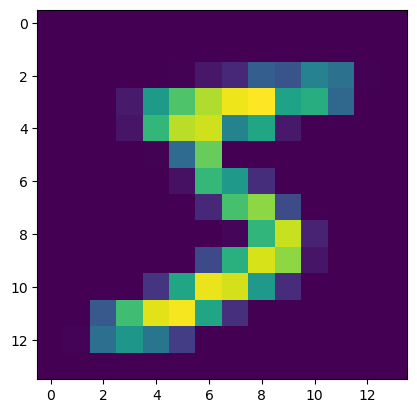

In [102]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as tfds
import numpy as np
onehot = lambda y : np.concatenate([
        (y == cifra)[:,None] * 1.
    for cifra in np.arange(10)
], axis = 1)

(x_train, y_train), (x_test, y_test) = tfds.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = np.array([ np.array(Image.fromarray(x).resize((14,14))) for x in x_train])
x_test  = np.array([ np.array(Image.fromarray(x).resize((14,14))) for x in x_test])

plt.imshow(x_train[0])

x_train = x_train.reshape(-1,14*14)
x_test  = x_test.reshape(-1,14*14)
y_test  = onehot(y_test)
y_train = onehot(y_train)



In [62]:
layer_sizes = [14*14, 10, 10, 10]
mask, params = init_network_params(layer_sizes, random.PRNGKey(0))
batched_predict(params,mask,x_train[:3])

DeviceArray([[-2.2986622, -2.3003092, -2.291753 , -2.3153772, -2.3010228,
              -2.3106387, -2.3008556, -2.309747 , -2.3073661, -2.2904146],
             [-2.2967458, -2.2978039, -2.290876 , -2.317737 , -2.3022969,
              -2.3089628, -2.301722 , -2.3104868, -2.3080108, -2.2915494],
             [-2.296296 , -2.2996867, -2.2964408, -2.3144908, -2.3035498,
              -2.3099043, -2.3052185, -2.307092 , -2.3107967, -2.2827616]],            dtype=float32)

# Training

In [103]:
layer_sizes = [14*14, 10, 10, 10]
step_size = 0.01
batch_epochs = 500
num_epochs = batch_epochs * 10
batch_size = 128
n_targets = 10
mask, params = init_network_params(layer_sizes, random.PRNGKey(0))

In [104]:
import time
mask, params = init_network_params(layer_sizes, random.PRNGKey(0))
for epoch in range(num_epochs):
    start_time = time.time()
    for i in range(10):
        batch = np.random.choice(len(x_train), size = 500)
        x,y = x_train[batch],y_train[batch]

    params = update(params, mask, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, mask, x_train, y_train)
    test_acc = accuracy(params, mask,  x_test, y_test)
    if epoch % batch_epochs == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_acc))
        print("Test set accuracy {}".format(test_acc))

Epoch 0 in 0.21 sec
Training set accuracy 0.10305000096559525
Test set accuracy 0.10610000044107437
Epoch 500 in 0.00 sec
Training set accuracy 0.16785000264644623
Test set accuracy 0.1678999960422516
Epoch 1000 in 0.00 sec
Training set accuracy 0.5564000010490417
Test set accuracy 0.5569999814033508
Epoch 1500 in 0.00 sec
Training set accuracy 0.7682666778564453
Test set accuracy 0.7785999774932861
Epoch 2000 in 0.00 sec
Training set accuracy 0.805066704750061
Test set accuracy 0.8119999766349792
Epoch 2500 in 0.00 sec
Training set accuracy 0.824733316898346
Test set accuracy 0.8294999599456787
Epoch 3000 in 0.00 sec
Training set accuracy 0.8372666835784912
Test set accuracy 0.8410999774932861
Epoch 3500 in 0.00 sec
Training set accuracy 0.8517166972160339
Test set accuracy 0.8529999852180481
Epoch 4000 in 0.00 sec
Training set accuracy 0.8665333390235901
Test set accuracy 0.8643999695777893
Epoch 4500 in 0.00 sec
Training set accuracy 0.8809999823570251
Test set accuracy 0.8792999982

# Sparsification

## Definiamo la distanza $d$ su $\mathcal P$
<center> $d(\theta,\theta') = || f_{\theta} - f_{\theta'} ||_{L^2(\Omega)}$ </center>

In [144]:
import jax
full_mask = get_full_mask(params)

def d(params_1, mask_1, params_2, mask_2 ):
    omega_sample = np.random.choice(255, size = (10000,14*14))
    return jnp.sum( (batched_predict(params_1, mask_1, omega_sample) - batched_predict(params_2, mask_2, omega_sample) )**2 )
d = jax.jit(d)
d_grad = jax.grad(d)
d_grad = jax.jit(d_grad)

params_perturbed = [ (p[0] + np.random.normal(size = p[0].shape) * .00001 ,p[1]) for p in params]

d(params,full_mask,params_perturbed,full_mask)

DeviceArray(2.018478, dtype=float32)

# LOOP di calcolo

In [159]:
# trovo il peso piú piccolo
import numpy as np

# inizializzo la maschera piena
full_mask = get_full_mask(params)
# inizializzo la maschera da svuotare
mask = get_full_mask(params)

def clone_params(params):
    return [  [ np.array(p[0]).copy(),np.array(p[1]).copy()] for p in params]

def adjust(params, mask, cmp_params, full_mask):
    new_params = clone_params(params)
    alfa       = 1e-11
    while alfa > 1e-14 :
        gradiente = d_grad(params,mask,cmp_params,full_mask)
        new_new_params = clone_params(new_params)
        for n,g in zip(new_new_params,gradiente):
            n[0] = n[0] - alfa * g[0]
            n[1] = n[1] - alfa * g[1]
            
        if(d(new_new_params,mask,cmp_params,full_mask) < d(new_params,mask,cmp_params,full_mask)):
            new_params = new_new_params
            alfa *= 1.001
        else:
            alfa *= 0.5
    return new_params

def prune(params, mask, cmp_params, doAdjust = True):
    minimo = 100.
    minimo_idx = 0
    minimo_i   = 0
    minimo_j   = 0
    
    for idx,p in enumerate(params):
        #print(idx)
        for i,row in enumerate(p[0]):
            #print("\t%d" % i , minimo)
            for j,el in enumerate(row):
                if params[idx][0][i,j] != 0.:
                    new_params = clone_params(params)
                    new_params[idx][0][i,j] = 0.
                    distanza =  d(cmp_params,full_mask,new_params,mask)
                    if(distanza < minimo):
                        minimo = distanza
                        minimo_idx = idx
                        minimo_i   = i
                        minimo_j   = j
                    if minimo == 0:         # if the minimum becomes zero then the current weight doees not affect distance in P space
                        # non ha bisogno di aggiustamento
                        mask[minimo_idx][minimo_i,minimo_j]          = 0. # setto la maschera  a 0
                        return new_params
    new_params = clone_params(params)
    new_params[minimo_idx][0][minimo_i,minimo_j] = 0.
    
    mask[minimo_idx][minimo_i,minimo_j]          = 0. # setto la maschera  a 0
    # ha bisogno di aggiustamento
    if doAdjust:
        new_params = adjust(new_params, mask, cmp_params,full_mask)
    
    return new_params

new_params = clone_params(params)
for i in range(500):
    new_params = prune(new_params, mask, params, True)
    NZ = np.sum([ (p[0] != 0).sum() for p in new_params]) # non zero entries
    print(accuracy(new_params,mask,  x_test, y_test) , NZ)

0.8883 2159
0.8883 2158
0.8883 2157
0.8883 2156
0.8883 2155
0.8883 2154
0.8883 2153
0.8883 2152
0.8883 2151
0.8883 2150
0.8883 2149
0.8883 2148
0.8883 2147
0.8883 2146
0.8883 2145
0.8883 2144
0.8883 2143
0.8883 2142
0.8883 2141
0.8883 2140
0.8883 2139
0.8883 2138
0.8883 2137
0.8883 2136
0.8883 2135
0.8883 2134
0.8883 2133
0.8883 2132
0.8883 2131
0.8883 2130
0.8883 2129
0.8883 2128
0.8883 2127
0.8883 2126
0.8883 2125
0.8883 2124
0.8883 2123
0.8883 2122
0.8883 2121
0.8883 2120
0.8883 2119
0.8883 2118
0.8883 2117
0.8883 2116
0.8883 2115
0.8883 2114
0.8883 2113
0.8883 2112
0.8883 2111
0.8883 2110
0.8883 2109
0.8883 2108
0.8883 2107
0.8883 2106
0.8883 2105
0.8883 2104
0.8883 2103
0.8883 2102
0.8883 2101
0.8883 2100
0.8883 2099
0.8883 2098
0.8883 2097
0.8883 2096
0.8883 2095
0.8883 2094
0.8883 2093
0.8883 2092
0.8883 2091
0.8883 2090
0.8883 2089
0.8883 2088
0.8883 2087
0.8883 2086
0.8883 2085
0.8883 2084
0.8883 2083
0.8883 2082
0.8883 2081
0.8883 2080
0.8883 2079
0.8883 2078
0.8883 2077
0.88

KeyboardInterrupt: 

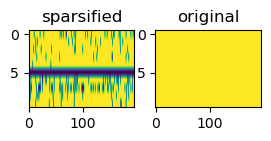

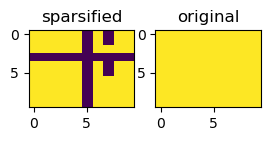

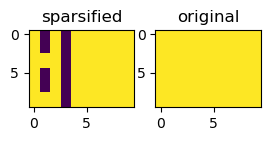

In [160]:
import matplotlib.pyplot as plt

for n,p in zip(new_params,params):
    axs = plt.figure(figsize=(3,1)).subplots(1,2)
    axs = axs.flatten()
    axs[0].set_title("sparsified")
    axs[0].imshow(n[0] != 0., vmin = 0.,vmax = 1.,aspect='auto') 
    axs[1].set_title("original")
    axs[1].imshow(p[0] != 0., vmin = 0.,vmax = 1.,aspect='auto')